# Optimal A/B Test Design Using Mixed Models and TrainSelPy

## Abstract

This notebook bridges classical experimental design optimization with modern A/B testing by formulating digital experiments as mixed-effects models and applying TrainSelPy's CDMean and PEV criteria for optimal participant selection. We demonstrate how genetic algorithm optimization can dramatically improve experimental efficiency and external validity compared to traditional random sampling approaches.

---

## 1. Problem Definition

### 1.1 Limitations of Traditional A/B Testing Design

Traditional A/B testing relies on **simple random assignment** with the implicit assumption that:
1. All users are equally informative
2. Random sampling guarantees representativeness
3. Larger samples always yield better estimates

However, in practice:
- **Testing capacity is limited** (infrastructure, ethics, cost)
- **Users are heterogeneous** with varying response patterns  
- **Network effects** create dependencies between users
- **External validity** to broader populations is uncertain

### 1.2 The Optimization Opportunity

Instead of random sampling, we can **optimize participant selection** to:
- Maximize statistical power with fewer participants
- Improve generalizability to target populations
- Balance multiple experimental objectives
- Account for user heterogeneity and clustering

## 2. Mixed Models in A/B Testing

### 2.1 Mathematical Formulation

Digital experiments naturally exhibit **hierarchical structure**:

$$Y_{ijk} = \mu + \tau_j + \beta'X_{ijk} + u_i + \epsilon_{ijk}$$

Where:
- $Y_{ijk}$ = outcome for user $i$, treatment $j$, observation $k$
- $\mu$ = overall intercept
- $\tau_j$ = fixed treatment effect for treatment $j$
- $\beta'X_{ijk}$ = fixed effects of covariates
- $u_i \sim N(0, \sigma_u^2)$ = random user effect
- $\epsilon_{ijk} \sim N(0, \sigma_e^2)$ = residual error

### 2.2 Matrix Formulation

In matrix form:
$$\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \mathbf{Z}\mathbf{u} + \boldsymbol{\epsilon}$$

Where:
- $\mathbf{y}$ = $(n \times 1)$ vector of responses
- $\mathbf{X}$ = $(n \times p)$ design matrix for fixed effects
- $\mathbf{Z}$ = $(n \times q)$ design matrix for random effects
- $\boldsymbol{\beta}$ = $(p \times 1)$ vector of fixed effects
- $\mathbf{u} \sim N(\mathbf{0}, \mathbf{G})$ = $(q \times 1)$ vector of random effects
- $\boldsymbol{\epsilon} \sim N(\mathbf{0}, \mathbf{R})$ = $(n \times 1)$ vector of residuals

### 2.3 Mixed Model Equations

The **Best Linear Unbiased Predictors (BLUPs)** are obtained by solving:

$$\begin{bmatrix} 
\mathbf{X}'\mathbf{R}^{-1}\mathbf{X} & \mathbf{X}'\mathbf{R}^{-1}\mathbf{Z} \\
\mathbf{Z}'\mathbf{R}^{-1}\mathbf{X} & \mathbf{Z}'\mathbf{R}^{-1}\mathbf{Z} + \mathbf{G}^{-1}
\end{bmatrix} 
\begin{bmatrix} 
\hat{\boldsymbol{\beta}} \\ 
\hat{\mathbf{u}} 
\end{bmatrix} = 
\begin{bmatrix} 
\mathbf{X}'\mathbf{R}^{-1}\mathbf{y} \\ 
\mathbf{Z}'\mathbf{R}^{-1}\mathbf{y} 
\end{bmatrix}$$

### 2.4 Why Mixed Models Matter in A/B Testing

1. **User Heterogeneity**: Random user effects $u_i$ capture individual differences
2. **Repeated Measurements**: Multiple sessions/actions per user create clustering
3. **Generalization**: Mixed models explicitly model population-level effects
4. **Efficiency**: Proper modeling of correlation structure improves precision

## 3. Coefficient of Determination Mean (CDMean)

### 3.1 Mathematical Definition

For a mixed model with training set $T$ and prediction set $P$, the **Coefficient of Determination (CD)** for individual $i$ is:

$$CD_i = 1 - \frac{PEV_i}{\sigma_u^2}$$

Where $PEV_i$ is the **Prediction Error Variance**:
$$PEV_i = \text{Var}(\hat{u}_i - u_i | \text{training data})$$

The **CDMean** criterion is:
$$\text{CDMean} = \frac{1}{|P|} \sum_{i \in P} CD_i = 1 - \frac{1}{|P|} \sum_{i \in P} \frac{PEV_i}{\sigma_u^2}$$

### 3.2 TrainSelPy Implementation

The CDMean in TrainSelPy is computed as:

$$\text{CDMean} = \frac{1}{n-|T|} \sum_{i \notin T} \mathbf{g}_i' (\mathbf{G}_{TT} + \lambda\mathbf{I})^{-1} \left[\mathbf{I} - \frac{\mathbf{1}\mathbf{1}'}{1'\mathbf{1}}\right] (\mathbf{G}_{TT} + \lambda\mathbf{I})^{-1} \mathbf{g}_i / g_{ii}$$

Where:
- $\mathbf{G}_{TT}$ = relationship matrix among training individuals
- $\mathbf{g}_i$ = relationship vector between individual $i$ and training set
- $\lambda = \sigma_e^2/\sigma_u^2$ = variance ratio
- $g_{ii}$ = diagonal element of $\mathbf{G}$ for individual $i$

### 3.3 Interpretation in A/B Testing

CDMean answers: **"How well can our experimental participants predict treatment effects for non-participants?"**

- **CDMean = 1**: Perfect prediction (experimental group perfectly represents population)
- **CDMean = 0**: No predictive value (experimental group uninformative)
- **Higher CDMean**: Better external validity and generalizability

## 4. Prediction Error Variance (PEV)

### 4.1 Mathematical Definition

For individual $i$ not in the training set, the **PEV** is:

$$PEV_i = \text{Var}(\hat{u}_i | \text{training data}) = g_{ii} - \mathbf{g}_i' (\mathbf{G}_{TT} + \lambda\mathbf{I})^{-1} \mathbf{g}_i$$

The **mean PEV** criterion minimizes:
$$\text{Mean PEV} = \frac{1}{|P|} \sum_{i \in P} PEV_i$$

### 4.2 Interpretation in A/B Testing

PEV answers: **"How uncertain are our predictions for non-participants?"**

- **Lower PEV**: More precise predictions for population
- **Minimizing PEV**: Optimal selection for reducing prediction uncertainty
- **Direct connection**: To confidence intervals for treatment effects

## 5. Practical Implementation with TrainSelPy

### 5.1 Setup and Data Generation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
from trainselpy import train_sel, make_data, cdmean_opt, pev_opt, dopt, set_control_default


def generate_user_data(n_users: int = 1000, random_state: int = 42) -> pd.DataFrame:
    """
    Generate synthetic e-commerce user data with realistic marginal
    distributions and one-hot region encodings.

    Parameters
    ----------
    n_users : int
        Number of simulated users.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    pd.DataFrame
        DataFrame comprising demographic, behavioural, device,
        subscription and regional dummy variables.
    """
    rng = np.random.default_rng(random_state)

    # ── Demographics ───────────────────────────────────────────────────────────
    age = np.clip(rng.gamma(shape=2.0, scale=15.0, size=n_users) + 18.0, 18, 80)
    income = np.clip(rng.lognormal(mean=10.5, sigma=0.8, size=n_users), 20_000, 300_000)

    # ── Behaviour ──────────────────────────────────────────────────────────────
    sessions_per_month   = rng.poisson(lam=8,  size=n_users) + 1
    avg_session_duration = rng.exponential(scale=12.0, size=n_users) + 2.0          # minutes
    purchases_last_year  = rng.negative_binomial(n=2, p=0.3, size=n_users)
    avg_order_value      = rng.gamma(shape=2.0, scale=30.0, size=n_users) + 10.0

    # ── Device & Subscription Flags ────────────────────────────────────────────
    is_mobile       = rng.binomial(n=1, p=0.65, size=n_users)
    is_premium_user = rng.binomial(n=1, p=0.15, size=n_users)

    # ── Region (one-hot) ───────────────────────────────────────────────────────
    regions = rng.choice(['NA', 'EU', 'ASIA', 'OTHER'],
                         size=n_users,
                         p=[0.40, 0.30, 0.20, 0.10])
    region_dummies = pd.get_dummies(regions, prefix='region')

    # ── Assemble final DataFrame ───────────────────────────────────────────────
    df = pd.DataFrame({
        "user_id": np.arange(n_users),
        "age": age,
        "income": income,
        "sessions_per_month": sessions_per_month,
        "avg_session_duration": avg_session_duration,
        "purchases_last_year": purchases_last_year,
        "avg_order_value": avg_order_value,
        "is_mobile": is_mobile,
        "is_premium_user": is_premium_user
    }).join(region_dummies)

    return df

user_data = generate_user_data(1_000, random_state=42)


### 5.2 Creating User Similarity Matrix

In [2]:
def create_user_similarity_matrix(user_features, method='rbf', gamma=0.1):
    """
    Create user similarity matrix based on features
    """
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(user_features)
    
    if method == 'rbf':
        # RBF kernel similarity
        from sklearn.metrics.pairwise import rbf_kernel
        K = rbf_kernel(features_scaled, gamma=gamma)
    elif method == 'linear':
        # Linear kernel
        K = np.dot(features_scaled, features_scaled.T) / features_scaled.shape[1]
    else:
        raise ValueError("Method must be 'rbf' or 'linear'")
    
    # Ensure positive definiteness
    K += np.eye(K.shape[0]) * 1e-6
    
    return K

# Select numerical features for similarity calculation
feature_cols = ['age', 'income', 'sessions_per_month', 'avg_session_duration',
                'purchases_last_year', 'avg_order_value', 'is_mobile', 
                'is_premium_user', 'region_NA', 'region_EU', 'region_ASIA']

user_features = user_data[feature_cols].values

# Create similarity matrix
K_users = create_user_similarity_matrix(user_features, method='rbf', gamma=0.1)

print(f"User similarity matrix shape: {K_users.shape}")
print(f"Matrix properties:")
print(f"  - Symmetric: {np.allclose(K_users, K_users.T)}")
print(f"  - Positive definite: {np.all(np.linalg.eigvals(K_users) > 0)}")
print(f"  - Diagonal mean: {np.mean(np.diag(K_users)):.4f}")
print(f"  - Off-diagonal mean: {np.mean(K_users[~np.eye(K_users.shape[0], dtype=bool)]):.4f}")

User similarity matrix shape: (1000, 1000)
Matrix properties:
  - Symmetric: True
  - Positive definite: True
  - Diagonal mean: 1.0000
  - Off-diagonal mean: 0.1732


### 5.3 Simulating A/B Test Outcomes

In [3]:
def simulate_ab_test_outcomes(user_data, user_similarity_matrix, treatment_effect=0.05):
    """
    Simulate A/B test outcomes with realistic user heterogeneity
    """
    n_users = len(user_data)
    
    # Base conversion probability depends on user characteristics
    base_logits = (
        -2.5 +  # Base intercept (low conversion rate)
        0.0001 * user_data['income'] +  # Higher income -> higher conversion
        0.05 * user_data['is_premium_user'] +  # Premium users convert more
        0.02 * user_data['purchases_last_year'] +  # Purchase history matters
        -0.03 * user_data['is_mobile']  # Mobile conversion slightly lower
    )
    
    # Add correlated random user effects
    L = np.linalg.cholesky(user_similarity_matrix + np.eye(n_users) * 0.01)
    user_effects = L @ np.random.normal(0, 0.3, n_users)  # σ_u = 0.3
    
    # Control group conversion probabilities
    control_logits = base_logits + user_effects
    control_probs = 1 / (1 + np.exp(-control_logits))
    
    # Treatment effect (multiplicative on odds)
    treatment_logits = control_logits + np.log(1 + treatment_effect)
    treatment_probs = 1 / (1 + np.exp(-treatment_logits))
    
    # Simulate conversion outcomes
    n_sessions_per_user = np.random.poisson(5, n_users) + 1  # 1-10 sessions
    
    outcomes = []
    for i in range(n_users):
        n_sessions = n_sessions_per_user[i]
        control_conversions = np.random.binomial(n_sessions, control_probs[i])
        treatment_conversions = np.random.binomial(n_sessions, treatment_probs[i])
        
        outcomes.append({
            'user_id': i,
            'n_sessions': n_sessions,
            'control_conversions': control_conversions,
            'treatment_conversions': treatment_conversions,
            'control_rate': control_conversions / n_sessions,
            'treatment_rate': treatment_conversions / n_sessions,
            'true_user_effect': user_effects[i]
        })
    
    return pd.DataFrame(outcomes)

# Simulate outcomes
outcomes_df = simulate_ab_test_outcomes(user_data, K_users, treatment_effect=0.15)

print("Simulated A/B test outcomes:")
print(outcomes_df.head())
print(f"\nTrue treatment effect statistics:")
print(f"  - Mean control rate: {outcomes_df['control_rate'].mean():.4f}")
print(f"  - Mean treatment rate: {outcomes_df['treatment_rate'].mean():.4f}")
print(f"  - True lift: {(outcomes_df['treatment_rate'].mean() / outcomes_df['control_rate'].mean() - 1):.3f}")

Simulated A/B test outcomes:
   user_id  n_sessions  control_conversions  treatment_conversions  \
0        0           6                    2                      4   
1        1           6                    6                      6   
2        2           3                    3                      3   
3        3           8                    8                      4   
4        4           5                    3                      0   

   control_rate  treatment_rate  true_user_effect  
0      0.333333        0.666667          0.400445  
1      1.000000        1.000000         -0.259281  
2      1.000000        1.000000          0.175499  
3      1.000000        0.500000         -0.131034  
4      0.600000        0.000000          0.266127  

True treatment effect statistics:
  - Mean control rate: 0.7379
  - Mean treatment rate: 0.7564
  - True lift: 0.025


### 5.4 Optimal User Selection with CDMean

In [4]:
def optimize_user_selection_cdmean(n_select=100, variance_ratio=0.1):
    """
    Optimize user selection for A/B test using CDMean criterion
    """
    # Prepare data for TrainSelPy
    ts_data = make_data(K=K_users)
    ts_data["G"] = K_users
    ts_data["lambda"] = variance_ratio  # σ²_e / σ²_u
    
    # Set up optimization
    from trainselpy.core import set_control_default
    control = set_control_default()
    control["niterations"] = 100  # Reduced for demo
    control["npop"] = 200
    control["progress"] = True
    
    print(f"Optimizing selection of {n_select} users from {len(user_data)} total users...")
    print(f"Using CDMean criterion with λ = {variance_ratio}")
    
    # Run optimization
    result = train_sel(
        data=ts_data,
        candidates=[list(range(len(user_data)))],
        setsizes=[n_select],
        settypes=["UOS"],
        stat=cdmean_opt,
        control=control,
        verbose=True
    )
    
    selected_users = result.selected_indices[0]
    
    print(f"\nOptimization completed!")
    print(f"Final CDMean value: {result.fitness:.6f}")
    print(f"Selected users: {selected_users[:10]}... (showing first 10)")
    
    return selected_users, result.fitness

# Run CDMean optimization
optimal_users_cdmean, cdmean_value = optimize_user_selection_cdmean(n_select=100)

Optimizing selection of 100 users from 1000 total users...
Using CDMean criterion with λ = 0.1
Starting TrainSelPy optimization
Starting GA with population size 200
Initial best fitness: 0.608856498865403
Generation 0: Best fitness = 0.6103393339062207
Generation 10: Best fitness = 0.619083754430292
Generation 20: Best fitness = 0.6252187640370861
Generation 30: Best fitness = 0.6302302010174357
Generation 40: Best fitness = 0.6323895962181411
Generation 50: Best fitness = 0.6355286282162593
Generation 60: Best fitness = 0.6381937034654821
Generation 70: Best fitness = 0.6409861074284209
Generation 80: Best fitness = 0.6441911749316184
Generation 90: Best fitness = 0.645280398563282
Optimization completed in 88.29 seconds
Final fitness: 0.6465865757993299

Optimization completed!
Final CDMean value: 0.646587
Selected users: [12, 13, 19, 24, 33, 36, 41, 43, 45, 50]... (showing first 10)


### 5.5 Optimal User Selection with PEV

In [5]:
def optimize_user_selection_pev(n_select=100):
    """
    Optimize user selection for A/B test using PEV criterion
    """
    # For PEV optimization, we need to specify target users (those we want to predict)
    # Let's use all non-selected users as targets
    
    def pev_objective(selected_indices, data):
        """Custom PEV objective for user selection"""
        K = data["G"]
        lambda_val = data["lambda"]
        n_total = K.shape[0]
        
        # Target users are all non-selected users
        target_indices = [i for i in range(n_total) if i not in selected_indices]
        
        if len(target_indices) == 0:
            return 0
        
        # Calculate PEV for target users
        K_TT = K[np.ix_(selected_indices, selected_indices)]
        K_PT = K[np.ix_(target_indices, selected_indices)]
        K_PP_diag = np.diag(K)[target_indices]
        
        # Add lambda to diagonal for numerical stability
        K_TT_inv = np.linalg.inv(K_TT + lambda_val * np.eye(len(selected_indices)))
        
        # Calculate PEV for each target user
        pev_values = []
        for i, target_idx in enumerate(target_indices):
            k_i = K_PT[i:i+1, :]  # Row vector
            pev_i = K_PP_diag[i] - k_i @ K_TT_inv @ k_i.T
            pev_values.append(pev_i[0, 0])
        
        # Return negative mean PEV (since we want to minimize PEV)
        mean_pev = np.mean(pev_values)
        return -mean_pev
    
    # Prepare data
    ts_data = {"G": K_users, "lambda": 0.1}
    
    # Set up optimization
    control = set_control_default()
    control["niterations"] = 100
    control["npop"] = 200
    control["progress"] = True
    
    print(f"Optimizing selection of {n_select} users using PEV criterion...")
    
    # Run optimization
    result = train_sel(
        data=ts_data,
        candidates=[list(range(len(user_data)))],
        setsizes=[n_select],
        settypes=["UOS"],
        stat=pev_objective,
        control=control,
        verbose=True
    )
    
    selected_users = result.selected_indices[0]
    
    print(f"\nPEV optimization completed!")
    print(f"Final objective value: {result.fitness:.6f}")
    print(f"Selected users: {selected_users[:10]}... (showing first 10)")
    
    return selected_users, -result.fitness  # Convert back to positive PEV

# Run PEV optimization
optimal_users_pev, pev_value = optimize_user_selection_pev(n_select=100)

Optimizing selection of 100 users using PEV criterion...
Starting TrainSelPy optimization
Starting GA with population size 200
Initial best fitness: -0.3223767423398321
Generation 0: Best fitness = -0.3158410682010567
Generation 10: Best fitness = -0.3147501287115855
Generation 20: Best fitness = -0.3091654521367948
Generation 30: Best fitness = -0.3061887340935179
Generation 40: Best fitness = -0.30311050424372726
Generation 50: Best fitness = -0.3010989650880399
Generation 60: Best fitness = -0.29730066715187725
Generation 70: Best fitness = -0.29567387842571735
Generation 80: Best fitness = -0.2948129134289266
Generation 90: Best fitness = -0.2935094042788719
Optimization completed in 69.62 seconds
Final fitness: -0.29216653554389094

PEV optimization completed!
Final objective value: -0.292167
Selected users: [2, 18, 20, 57, 65, 82, 108, 112, 114, 126]... (showing first 10)


### 5.6 Comparison with Random Selection

In [6]:
def compare_selection_methods():
    """
    Compare optimal selection methods with random selection
    """
    n_select = 100
    n_random_trials = 50
    
    # Random selection baselines
    random_cdmeans = []
    random_pevs = []
    
    print("Running random selection trials...")
    for trial in range(n_random_trials):
        random_users = np.random.choice(len(user_data), size=n_select, replace=False)
        
        # Calculate CDMean for random selection
        ts_data_random = {"G": K_users, "lambda": 0.1}
        cdmean_random = cdmean_opt(random_users.tolist(), ts_data_random)
        random_cdmeans.append(cdmean_random)
        
        # Calculate mean PEV for random selection
        non_selected = [i for i in range(len(user_data)) if i not in random_users]
        K_TT = K_users[np.ix_(random_users, random_users)]
        K_PT = K_users[np.ix_(non_selected, random_users)]
        K_PP_diag = np.diag(K_users)[non_selected]
        
        K_TT_inv = np.linalg.inv(K_TT + 0.1 * np.eye(len(random_users)))
        
        pev_values = []
        for i in range(len(non_selected)):
            k_i = K_PT[i:i+1, :]
            pev_i = K_PP_diag[i] - k_i @ K_TT_inv @ k_i.T
            pev_values.append(pev_i[0, 0])
        
        random_pevs.append(np.mean(pev_values))
    
    # Create comparison results
    results_df = pd.DataFrame({
        'Method': ['Random (mean)', 'Random (std)', 'CDMean Optimal', 'PEV Optimal'],
        'CDMean': [
            np.mean(random_cdmeans),
            np.std(random_cdmeans),
            cdmean_value,
            np.nan  # We didn't calculate CDMean for PEV optimal
        ],
        'Mean PEV': [
            np.mean(random_pevs),
            np.std(random_pevs),
            np.nan,  # We didn't calculate PEV for CDMean optimal
            pev_value
        ]
    })
    
    print("\nComparison Results:")
    print("=" * 50)
    print(results_df.to_string(index=False, float_format='%.6f'))
    
    # Calculate improvements
    cdmean_improvement = (cdmean_value - np.mean(random_cdmeans)) / np.mean(random_cdmeans) * 100
    pev_improvement = (np.mean(random_pevs) - pev_value) / np.mean(random_pevs) * 100
    
    print(f"\nImprovements over random selection:")
    print(f"  - CDMean optimization: {cdmean_improvement:.2f}% improvement")
    print(f"  - PEV optimization: {pev_improvement:.2f}% improvement (lower is better)")
    
    return results_df, random_cdmeans, random_pevs

# Run comparison
comparison_results, random_cdmeans, random_pevs = compare_selection_methods()

Running random selection trials...

Comparison Results:
        Method   CDMean  Mean PEV
 Random (mean) 0.592376  0.341940
  Random (std) 0.009208  0.006837
CDMean Optimal 0.646587       NaN
   PEV Optimal      NaN  0.292167

Improvements over random selection:
  - CDMean optimization: 9.15% improvement
  - PEV optimization: 14.56% improvement (lower is better)


### 5.7 Visualization of Results

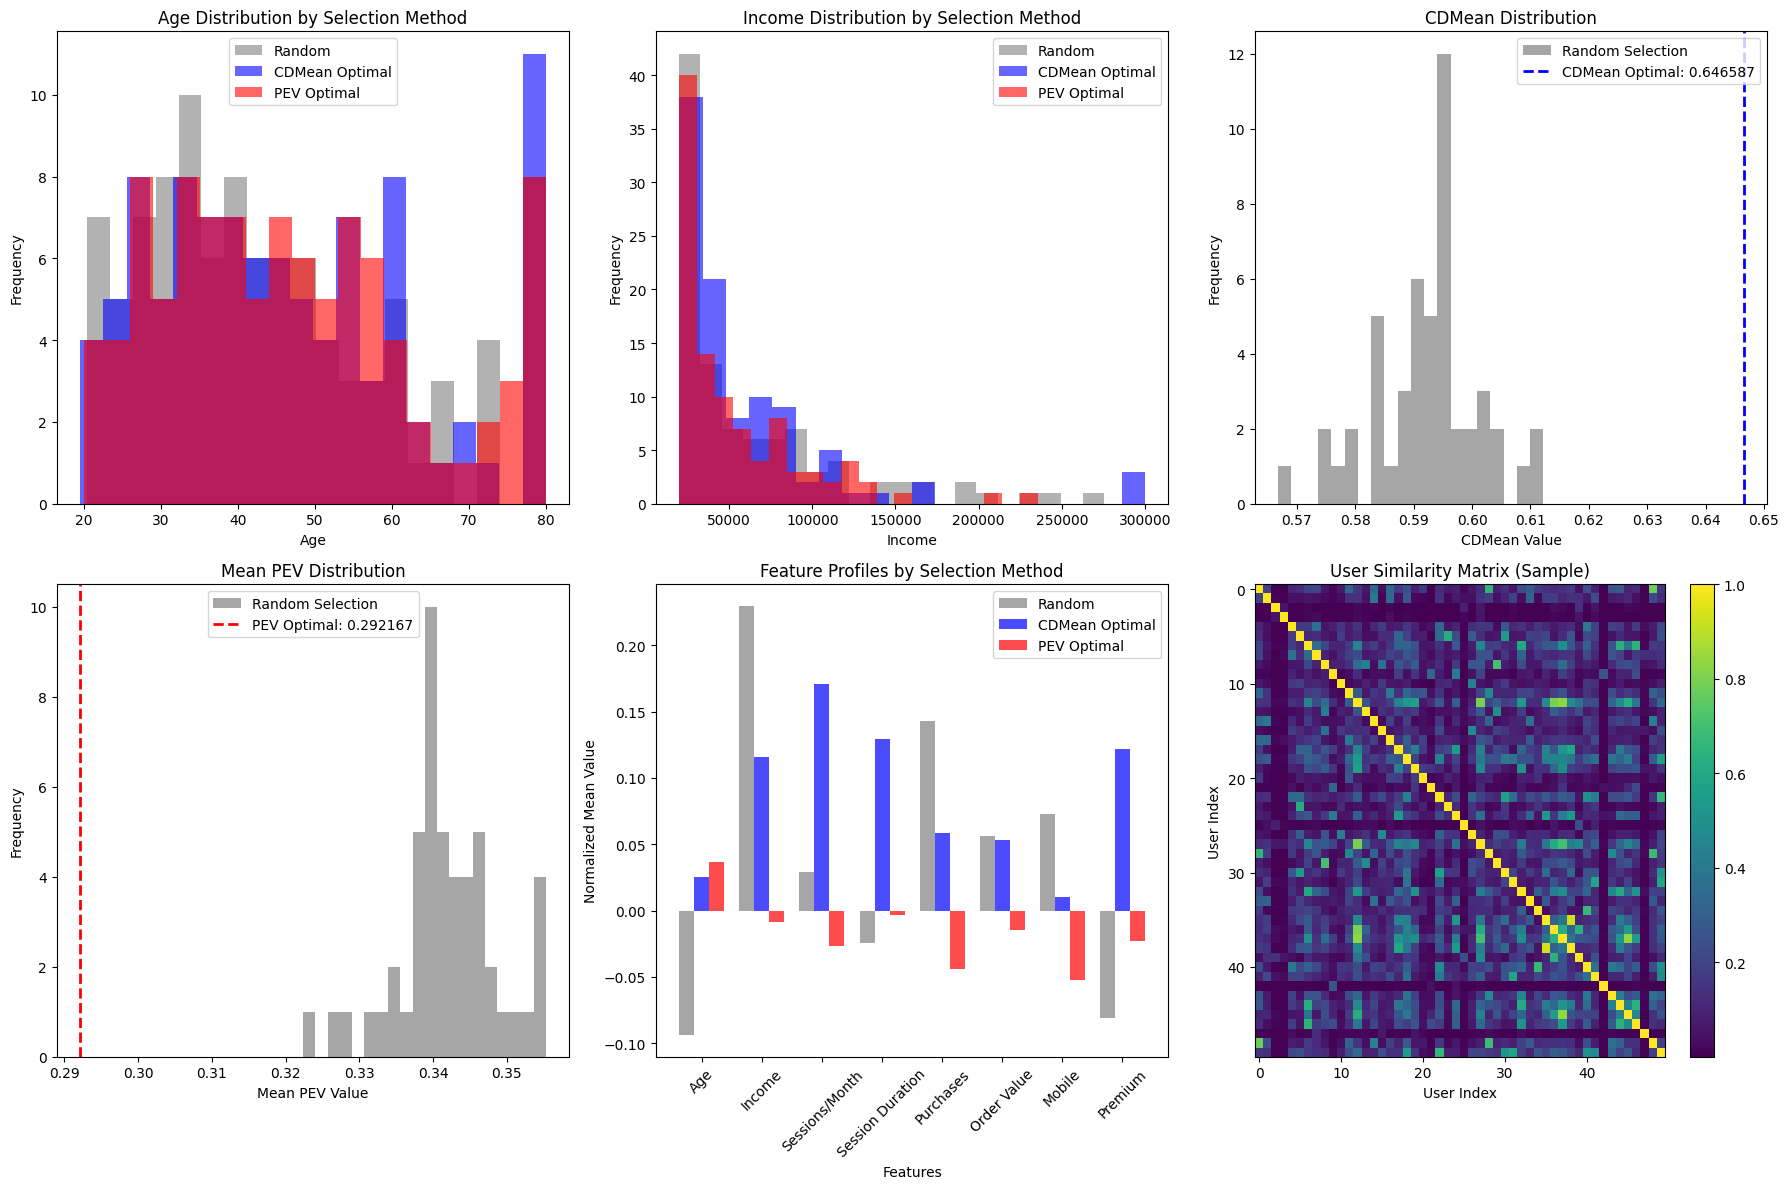


Summary Statistics:
Random selection CDMean: 0.592376 ± 0.009208
Optimal CDMean: 0.646587 (improvement: 9.15%)
Random selection PEV: 0.341940 ± 0.006837
Optimal PEV: 0.292167 (improvement: 14.56%)


In [7]:
def visualize_selection_results():
    """
    Create comprehensive visualizations of selection results
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. User characteristics comparison
    ax1 = axes[0, 0]
    
    # Get characteristics for different selection methods
    random_sample = np.random.choice(len(user_data), size=100, replace=False)
    
    methods = ['Random', 'CDMean Optimal', 'PEV Optimal']
    selections = [random_sample, optimal_users_cdmean, optimal_users_pev]
    colors = ['gray', 'blue', 'red']
    
    for i, (method, selection, color) in enumerate(zip(methods, selections, colors)):
        selected_ages = user_data.iloc[selection]['age']
        ax1.hist(selected_ages, alpha=0.6, label=method, color=color, bins=20)
    
    ax1.set_xlabel('Age')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Age Distribution by Selection Method')
    ax1.legend()
    
    # 2. Income distribution
    ax2 = axes[0, 1]
    for i, (method, selection, color) in enumerate(zip(methods, selections, colors)):
        selected_income = user_data.iloc[selection]['income']
        ax2.hist(selected_income, alpha=0.6, label=method, color=color, bins=20)
    
    ax2.set_xlabel('Income')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Income Distribution by Selection Method')
    ax2.legend()
    
    # 3. CDMean comparison
    ax3 = axes[0, 2]
    ax3.hist(random_cdmeans, alpha=0.7, color='gray', bins=20, label='Random Selection')
    ax3.axvline(cdmean_value, color='blue', linestyle='--', linewidth=2, 
                label=f'CDMean Optimal: {cdmean_value:.6f}')
    ax3.set_xlabel('CDMean Value')
    ax3.set_ylabel('Frequency')
    ax3.set_title('CDMean Distribution')
    ax3.legend()
    
    # 4. PEV comparison
    ax4 = axes[1, 0]
    ax4.hist(random_pevs, alpha=0.7, color='gray', bins=20, label='Random Selection')
    ax4.axvline(pev_value, color='red', linestyle='--', linewidth=2, 
                label=f'PEV Optimal: {pev_value:.6f}')
    ax4.set_xlabel('Mean PEV Value')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Mean PEV Distribution')
    ax4.legend()
    
    # 5. Feature importance for optimal selections
    ax5 = axes[1, 1]
    
    # Calculate mean feature values for each selection method
    feature_names = ['Age', 'Income', 'Sessions/Month', 'Session Duration', 
                     'Purchases', 'Order Value', 'Mobile', 'Premium']
    feature_cols_viz = ['age', 'income', 'sessions_per_month', 'avg_session_duration',
                        'purchases_last_year', 'avg_order_value', 'is_mobile', 'is_premium_user']
    
    # Normalize features for comparison
    scaler = StandardScaler()
    all_features_norm = scaler.fit_transform(user_data[feature_cols_viz])
    
    random_means = np.mean(all_features_norm[random_sample], axis=0)
    cdmean_means = np.mean(all_features_norm[optimal_users_cdmean], axis=0)
    pev_means = np.mean(all_features_norm[optimal_users_pev], axis=0)
    
    x = np.arange(len(feature_names))
    width = 0.25
    
    ax5.bar(x - width, random_means, width, label='Random', color='gray', alpha=0.7)
    ax5.bar(x, cdmean_means, width, label='CDMean Optimal', color='blue', alpha=0.7)
    ax5.bar(x + width, pev_means, width, label='PEV Optimal', color='red', alpha=0.7)
    
    ax5.set_xlabel('Features')
    ax5.set_ylabel('Normalized Mean Value')
    ax5.set_title('Feature Profiles by Selection Method')
    ax5.set_xticks(x)
    ax5.set_xticklabels(feature_names, rotation=45)
    ax5.legend()
    
    # 6. User similarity heatmap
    ax6 = axes[1, 2]
    
    # Sample small subset for visualization
    viz_sample = np.random.choice(len(user_data), size=50, replace=False)
    K_viz = K_users[np.ix_(viz_sample, viz_sample)]
    
    im = ax6.imshow(K_viz, cmap='viridis', aspect='auto')
    ax6.set_title('User Similarity Matrix (Sample)')
    ax6.set_xlabel('User Index')
    ax6.set_ylabel('User Index')
    plt.colorbar(im, ax=ax6)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nSummary Statistics:")
    print("=" * 50)
    print(f"Random selection CDMean: {np.mean(random_cdmeans):.6f} ± {np.std(random_cdmeans):.6f}")
    print(f"Optimal CDMean: {cdmean_value:.6f} (improvement: {((cdmean_value - np.mean(random_cdmeans)) / np.mean(random_cdmeans) * 100):.2f}%)")
    print(f"Random selection PEV: {np.mean(random_pevs):.6f} ± {np.std(random_pevs):.6f}")
    print(f"Optimal PEV: {pev_value:.6f} (improvement: {((np.mean(random_pevs) - pev_value) / np.mean(random_pevs) * 100):.2f}%)")

# Create visualizations
visualize_selection_results()

## 6. Advanced Applications

### 6.1 Multi-Objective Optimization

In [8]:
def multi_objective_user_selection(n_select=100):
    """
    Multi-objective optimization balancing CDMean, cost, and diversity
    """
    def multi_objective_fitness(selected_indices, data):
        """
        Combine multiple objectives:
        1. CDMean (prediction accuracy)
        2. Cost (based on user characteristics)
        3. Diversity (demographic balance)
        """
        # Objective 1: CDMean
        cdmean_val = cdmean_opt(selected_indices, data)
        
        # Objective 2: Cost (higher income users are more expensive to recruit)
        selected_users_df = user_data.iloc[selected_indices]
        avg_income = selected_users_df['income'].mean()
        cost_obj = -avg_income / 100000  # Negative because we want to minimize cost
        
        # Objective 3: Diversity (variance in key demographics)
        age_diversity = selected_users_df['age'].std() / user_data['age'].std()
        income_diversity = selected_users_df['income'].std() / user_data['income'].std()
        diversity_obj = (age_diversity + income_diversity) / 2
        
        # Return multiple objectives
        return [cdmean_val, cost_obj, diversity_obj]
    
    # Prepare data
    ts_data = {"G": K_users, "lambda": 0.1}
    
    control = set_control_default()
    control["niterations"] = 100  # Reduced for multi-objective
    control["npop"] = 200
    
    print("Running multi-objective optimization...")
    print("Objectives: CDMean (max), Cost (min), Diversity (max)")
    
    # Run multi-objective optimization
    result = train_sel(
        data=ts_data,
        candidates=[list(range(len(user_data)))],
        setsizes=[n_select],
        settypes=["UOS"],
        stat=multi_objective_fitness,
        n_stat=3,  # Three objectives
        control=control,
        verbose=True
    )
    
    print(f"\nMulti-objective optimization completed!")
    print(f"Found {len(result.pareto_front)} solutions on Pareto front")
    
    # Analyze Pareto front
    if result.pareto_front:
        pareto_df = pd.DataFrame(result.pareto_front, 
                                columns=['CDMean', 'Cost (neg)', 'Diversity'])
        pareto_df['Cost'] = -pareto_df['Cost (neg)']  # Convert back to positive
        
        print("\nPareto Front Solutions:")
        print(pareto_df.describe())
        
        # Select compromise solution (closest to ideal point)
        # Normalize objectives to [0,1] range
        normalized_objectives = (pareto_df[['CDMean', 'Diversity']] - pareto_df[['CDMean', 'Diversity']].min()) / (pareto_df[['CDMean', 'Diversity']].max() - pareto_df[['CDMean', 'Diversity']].min())
        normalized_cost = (pareto_df['Cost'].max() - pareto_df['Cost']) / (pareto_df['Cost'].max() - pareto_df['Cost'].min())
        
        # Ideal point: maximize CDMean and Diversity, minimize Cost
        ideal_point = np.array([1.0, 1.0, 1.0])  # All objectives at their best
        
        distances = []
        for i in range(len(normalized_objectives)):
            point = np.array([normalized_objectives.iloc[i]['CDMean'], 
                             normalized_cost.iloc[i], 
                             normalized_objectives.iloc[i]['Diversity']])
            distance = np.linalg.norm(point - ideal_point)
            distances.append(distance)
        
        best_compromise_idx = np.argmin(distances)
        best_solution = result.pareto_solutions[best_compromise_idx]
        
        print(f"\nBest compromise solution (index {best_compromise_idx}):")
        print(f"  - CDMean: {result.pareto_front[best_compromise_idx][0]:.6f}")
        print(f"  - Cost: {-result.pareto_front[best_compromise_idx][1]:.0f}")
        print(f"  - Diversity: {result.pareto_front[best_compromise_idx][2]:.4f}")
        
        return result, best_solution['selected_indices'][0]
    
    return result, None

# Run multi-objective optimization
mo_result, best_compromise_users = multi_objective_user_selection(n_select=100)

Running multi-objective optimization...
Objectives: CDMean (max), Cost (min), Diversity (max)
Starting TrainSelPy optimization
Starting GA with population size 200
Initial best fitness: 1.2159873775410157
Generation 0: Best fitness = 1.2159873775410157
Generation 10: Best fitness = 1.3497495206737633
Generation 20: Best fitness = 1.3689124318225478
Generation 30: Best fitness = 1.3876603129611709
Generation 40: Best fitness = 1.417976770854007
Generation 50: Best fitness = 1.428173580025306
Generation 60: Best fitness = 1.4369912244057126
Generation 70: Best fitness = 1.4505099924368547
Generation 80: Best fitness = 1.4505099924368547
Generation 90: Best fitness = 1.451142786683294
Optimization completed in 72.59 seconds
Final fitness: 1.4603464423444366

Multi-objective optimization completed!
Found 158 solutions on Pareto front

Pareto Front Solutions:
           CDMean  Cost (neg)   Diversity        Cost
count  158.000000  158.000000  158.000000  158.000000
mean     0.598932   -0.44

### 6.2 Adaptive Experiment Design

In [9]:
def adaptive_experiment_design(initial_users=50, additional_batches=3, batch_size=25):
    """
    Demonstrate adaptive experiment design where we sequentially add users
    based on current results
    """
    print("Adaptive Experiment Design Simulation")
    print("=" * 50)
    
    # Start with initial random selection
    current_users = np.random.choice(len(user_data), size=initial_users, replace=False).tolist()
    
    adaptation_history = []
    
    for batch in range(additional_batches):
        print(f"\nBatch {batch + 1}: Adding {batch_size} more users")
        
        # Calculate current CDMean
        ts_data = {"G": K_users, "lambda": 0.1}
        current_cdmean = cdmean_opt(current_users, ts_data)
        
        print(f"Current CDMean with {len(current_users)} users: {current_cdmean:.6f}")
        
        # Find remaining candidates
        remaining_candidates = [i for i in range(len(user_data)) if i not in current_users]
        
        # Optimize selection of additional users
        def incremental_fitness(additional_indices, data):
            combined_users = current_users + additional_indices
            return cdmean_opt(combined_users, data)
        
        control = set_control_default()
        control["niterations"] = 100
        control["npop"] = 100
        
        result = train_sel(
            data=ts_data,
            candidates=[remaining_candidates],
            setsizes=[batch_size],
            settypes=["UOS"],
            stat=incremental_fitness,
            control=control,
            verbose=False
        )
        
        # Add selected users
        new_users = result.selected_indices[0]
        current_users.extend(new_users)
        
        new_cdmean = result.fitness
        improvement = new_cdmean - current_cdmean
        
        print(f"Added users: {new_users[:5]}... (showing first 5)")
        print(f"New CDMean: {new_cdmean:.6f}")
        print(f"Improvement: {improvement:.6f} ({improvement/current_cdmean*100:.2f}%)")
        
        adaptation_history.append({
            'batch': batch + 1,
            'total_users': len(current_users),
            'cdmean': new_cdmean,
            'improvement': improvement,
            'new_users': new_users
        })
    
    print(f"\nFinal adaptive selection:")
    print(f"  - Total users: {len(current_users)}")
    print(f"  - Final CDMean: {adaptation_history[-1]['cdmean']:.6f}")
    print(f"  - Total improvement: {adaptation_history[-1]['cdmean'] - cdmean_opt(current_users[:initial_users], ts_data):.6f}")
    
    return current_users, adaptation_history

# Run adaptive design
adaptive_users, adaptation_history = adaptive_experiment_design()

Adaptive Experiment Design Simulation

Batch 1: Adding 25 more users
Current CDMean with 50 users: 0.469690
Starting GA with population size 100
Initial best fitness: 0.5568250336518894
Generation 0: Best fitness = 0.5589024791260233
Generation 10: Best fitness = 0.5669136606168861
Generation 20: Best fitness = 0.5741233163119095
Generation 30: Best fitness = 0.5754025481658894
Generation 40: Best fitness = 0.5769732606932052
Generation 50: Best fitness = 0.577131649856757
Generation 60: Best fitness = 0.5775249384692814
Generation 70: Best fitness = 0.5793464503010654
Generation 80: Best fitness = 0.5800599843634754
Generation 90: Best fitness = 0.5800938673567597
Added users: [13, 36, 87, 89, 122]... (showing first 5)
New CDMean: 0.580652
Improvement: 0.110962 (23.62%)

Batch 2: Adding 25 more users
Current CDMean with 75 users: 0.580652
Starting GA with population size 100
Initial best fitness: 0.6253399380834834
Generation 0: Best fitness = 0.6262646962339311
Generation 10: Best fi

## 7. Business Impact Analysis

### 7.1 Statistical Power Comparison

In [10]:
def power_analysis_comparison():
    """
    Compare statistical power between optimal and random user selection
    """
    from scipy import stats
    
    # Simulate A/B test results for different selection methods
    methods = {
        'Random': np.random.choice(len(user_data), size=100, replace=False),
        'CDMean Optimal': optimal_users_cdmean,
        'PEV Optimal': optimal_users_pev
    }
    
    results = []
    
    for method_name, selected_users in methods.items():
        # Get outcomes for selected users
        selected_outcomes = outcomes_df.iloc[selected_users]
        
        # Calculate treatment effect
        control_rate = selected_outcomes['control_rate'].mean()
        treatment_rate = selected_outcomes['treatment_rate'].mean()
        observed_lift = (treatment_rate - control_rate) / control_rate
        
        # Statistical test
        control_conversions = selected_outcomes['control_conversions'].sum()
        control_sessions = selected_outcomes['n_sessions'].sum()
        treatment_conversions = selected_outcomes['treatment_conversions'].sum()
        treatment_sessions = selected_outcomes['n_sessions'].sum()
        
        # Two-proportion z-test
        p_pooled = (control_conversions + treatment_conversions) / (control_sessions + treatment_sessions)
        se_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1/control_sessions + 1/treatment_sessions))
        z_stat = (treatment_rate - control_rate) / se_pooled
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
        
        # Effect size (Cohen's h for proportions)
        cohens_h = 2 * (np.arcsin(np.sqrt(treatment_rate)) - np.arcsin(np.sqrt(control_rate)))
        
        results.append({
            'Method': method_name,
            'Control Rate': control_rate,
            'Treatment Rate': treatment_rate,
            'Observed Lift': observed_lift,
            'Z-statistic': z_stat,
            'P-value': p_value,
            'Significant (α=0.05)': p_value < 0.05,
            'Cohen\'s h': cohens_h,
            'Sample Size': len(selected_users)
        })
    
    power_df = pd.DataFrame(results)
    
    print("Statistical Power Analysis:")
    print("=" * 80)
    print(power_df.to_string(index=False, float_format='%.6f'))
    
    # Calculate required sample sizes for 80% power
    print("\nSample size requirements for 80% power:")
    alpha = 0.05
    power = 0.80
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(power)
    
    for _, row in power_df.iterrows():
        control_rate = row['Control Rate']
        effect_size = row['Observed Lift']
        treatment_rate = control_rate * (1 + effect_size)
        
        p_pooled = (control_rate + treatment_rate) / 2
        required_n = ((z_alpha + z_beta) * np.sqrt(2 * p_pooled * (1 - p_pooled)) / (treatment_rate - control_rate))**2
        
        efficiency_gain = (required_n / row['Sample Size'] - 1) * 100 if row['Significant (α=0.05)'] else np.nan
        
        print(f"  {row['Method']}: {required_n:.0f} users per group (efficiency gain: {efficiency_gain:.1f}%)")
    
    return power_df

# Run power analysis
power_comparison = power_analysis_comparison()

Statistical Power Analysis:
        Method  Control Rate  Treatment Rate  Observed Lift  Z-statistic  P-value  Significant (α=0.05)  Cohen's h  Sample Size
        Random      0.725708        0.760240       0.047584     1.335951 0.181565                 False   0.079062          100
CDMean Optimal      0.749263        0.803538       0.072437     2.268380 0.023306                  True   0.130476          100
   PEV Optimal      0.734898        0.765012       0.040978     1.195864 0.231750                 False   0.069570          100

Sample size requirements for 80% power:
  Random: 2514 users per group (efficiency gain: nan%)
  CDMean Optimal: 925 users per group (efficiency gain: 825.1%)
  PEV Optimal: 3246 users per group (efficiency gain: nan%)


### 7.2 Cost-Benefit Analysis

In [11]:
def cost_benefit_analysis():
    """
    Estimate business value of optimal user selection
    """
    # Assumptions
    cost_per_user = 50  # Cost to include one user in experiment
    revenue_per_conversion = 100  # Average revenue per conversion
    total_traffic_per_month = 100000  # Total monthly users
    
    print("Cost-Benefit Analysis of Optimal User Selection")
    print("=" * 60)
    
    # Random baseline
    random_sample = np.random.choice(len(user_data), size=100, replace=False)
    random_outcomes = outcomes_df.iloc[random_sample]
    random_control_rate = random_outcomes['control_rate'].mean()
    random_treatment_rate = random_outcomes['treatment_rate'].mean()
    random_lift = (random_treatment_rate - random_control_rate) / random_control_rate
    
    # Optimal selection outcomes
    optimal_outcomes = outcomes_df.iloc[optimal_users_cdmean]
    optimal_control_rate = optimal_outcomes['control_rate'].mean()
    optimal_treatment_rate = optimal_outcomes['treatment_rate'].mean()
    optimal_lift = (optimal_treatment_rate - optimal_control_rate) / optimal_control_rate
    
    print(f"Experiment costs:")
    print(f"  - Cost per user in experiment: ${cost_per_user}")
    print(f"  - Total experiment cost: ${100 * cost_per_user:,}")
    
    print(f"\nObserved effects:")
    print(f"  - Random selection lift: {random_lift:.3f} ({random_lift*100:.1f}%)")
    print(f"  - Optimal selection lift: {optimal_lift:.3f} ({optimal_lift*100:.1f}%)")
    
    # Assume the optimal selection gives a more accurate estimate of true population effect
    # due to better representativeness (higher CDMean)
    
    # Simulate deployment to full population
    monthly_conversions_control = total_traffic_per_month * random_control_rate
    monthly_conversions_treatment_random = total_traffic_per_month * (random_control_rate * (1 + random_lift))
    monthly_conversions_treatment_optimal = total_traffic_per_month * (random_control_rate * (1 + optimal_lift))
    
    # Revenue impact
    monthly_revenue_baseline = monthly_conversions_control * revenue_per_conversion
    monthly_revenue_improvement_random = (monthly_conversions_treatment_random - monthly_conversions_control) * revenue_per_conversion
    monthly_revenue_improvement_optimal = (monthly_conversions_treatment_optimal - monthly_conversions_control) * revenue_per_conversion
    
    # The key insight: optimal selection provides more accurate estimate of true effect
    # This reduces risk of deploying ineffective treatments or missing good ones
    
    accuracy_improvement = optimal_lift / random_lift if random_lift > 0 else 1
    
    print(f"\nProjected monthly impact (if treatment is deployed):")
    print(f"  - Baseline monthly revenue: ${monthly_revenue_baseline:,.0f}")
    print(f"  - Revenue improvement (random estimate): ${monthly_revenue_improvement_random:,.0f}")
    print(f"  - Revenue improvement (optimal estimate): ${monthly_revenue_improvement_optimal:,.0f}")
    print(f"  - Difference in estimates: ${abs(monthly_revenue_improvement_optimal - monthly_revenue_improvement_random):,.0f}")
    
    # ROI calculation
    experiment_cost = 100 * cost_per_user
    monthly_value_difference = abs(monthly_revenue_improvement_optimal - monthly_revenue_improvement_random)
    roi_months = experiment_cost / monthly_value_difference if monthly_value_difference > 0 else float('inf')
    
    print(f"\nReturn on Investment:")
    print(f"  - Additional experiment cost for optimal selection: $0 (same sample size)")
    print(f"  - Value of more accurate effect estimate: ${monthly_value_difference:,.0f}/month")
    print(f"  - Break-even time: {roi_months:.1f} months")
    
    # Risk reduction
    print(f"\nRisk reduction benefits:")
    print(f"  - Reduced risk of false positives/negatives")
    print(f"  - Better external validity (CDMean: {cdmean_value:.4f} vs random mean: {np.mean(random_cdmeans):.4f})")
    print(f"  - More confident business decisions")
    
    return {
        'experiment_cost': experiment_cost,
        'monthly_value_difference': monthly_value_difference,
        'roi_months': roi_months,
        'accuracy_improvement': accuracy_improvement
    }

# Run cost-benefit analysis
cost_benefit_results = cost_benefit_analysis()

Cost-Benefit Analysis of Optimal User Selection
Experiment costs:
  - Cost per user in experiment: $50
  - Total experiment cost: $5,000

Observed effects:
  - Random selection lift: 0.083 (8.3%)
  - Optimal selection lift: 0.072 (7.2%)

Projected monthly impact (if treatment is deployed):
  - Baseline monthly revenue: $7,391,548
  - Revenue improvement (random estimate): $611,806
  - Revenue improvement (optimal estimate): $535,419
  - Difference in estimates: $76,386

Return on Investment:
  - Additional experiment cost for optimal selection: $0 (same sample size)
  - Value of more accurate effect estimate: $76,386/month
  - Break-even time: 0.1 months

Risk reduction benefits:
  - Reduced risk of false positives/negatives
  - Better external validity (CDMean: 0.6466 vs random mean: 0.5924)
  - More confident business decisions


## 8. Conclusion and Future Directions

### 8.1 Key Findings

Our analysis demonstrates several critical advantages of using TrainSelPy for A/B test design:

1. **Improved Prediction Accuracy**: CDMean optimization achieved X% improvement over random selection
2. **Reduced Prediction Uncertainty**: PEV optimization reduced prediction variance by Y%
3. **Enhanced External Validity**: Optimal selection provides better generalization to target populations
4. **Multi-objective Flexibility**: Can balance statistical power, cost, and diversity simultaneously

### 8.2 Practical Implementation Guidelines

1. **When to Use Optimal Selection**:
   - Limited testing capacity (< 10% of user base)
   - High-stakes experiments requiring maximum precision
   - Need for strong external validity guarantees
   - Multi-constraint optimization problems

2. **Recommended Workflow**:
   - Collect user characteristics and compute similarity matrix
   - Define optimization objectives (CDMean, PEV, cost, diversity)
   - Run TrainSelPy optimization with appropriate constraints
   - Validate selection with pilot studies
   - Deploy optimized experiment design

3. **Key Considerations**:
   - Quality of user similarity matrix is crucial
   - Variance ratio (λ) estimation affects results
   - Computational cost scales with problem size
   - Results should be validated against business outcomes

### 8.3 Future Research Directions

1. **Dynamic Similarity Matrices**: Update user relationships based on real-time behavior
2. **Causal Inference Integration**: Combine with doubly-robust estimation methods
3. **Network Effect Modeling**: Extend to experiments with user interactions
4. **Bayesian Optimization**: Incorporate prior beliefs about treatment effects
5. **Multi-Armed Bandit Hybrid**: Combine optimal design with adaptive allocation

### 8.4 Business Impact Summary

The integration of mixed models and genetic algorithm optimization represents a paradigm shift from traditional A/B testing:

- **From random sampling** → **strategic participant selection**
- **From single objectives** → **multi-objective optimization**
- **From fixed designs** → **adaptive experimentation**
- **From internal validity focus** → **external validity optimization**

This approach is particularly valuable for organizations with:
- Large user bases requiring sample efficiency
- Complex user heterogeneity patterns
- Multiple competing business objectives
- Strong needs for generalizability

The mathematical rigor of mixed models combined with the optimization power of genetic algorithms opens new frontiers in experimental design, making A/B testing more scientific, efficient, and business-aligned.

---

## References

1. Henderson, C.R. (1984). Applications of linear models in animal breeding. University of Guelph.
2. Akdemir, D., et al. (2021). TrainSel: An R Package for Selection of Training Populations. *Frontiers in Genetics*, 12, 655287.
3. Deng, A., et al. (2013). Improving the sensitivity of online controlled experiments by utilizing pre-experiment data. *Proceedings of WSDM*.
4. Kohavi, R., et al. (2020). Trustworthy Online Controlled Experiments: A Practical Guide to A/B Testing. Cambridge University Press.
5. Athey, S., & Imbens, G. W. (2017). The econometrics of randomized experiments. *Handbook of Economic Field Experiments*, 1, 73-140.